# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved.
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server.

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [ ]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [ ]:

# Read the words from the file
with open('words_250000_train.txt', 'r') as f:
    words = f.read().splitlines()

# Calculate the length of each word
lengths = [len(word) for word in words]

# Count the occurrences of each length
length_counts = Counter(lengths)

# Calculate the percentage of each length
total_words = len(words)
length_percentages = {length: (count / total_words) * 100 for length, count in length_counts.items()}

# Find the length with the highest percentage
max_length = max(length_percentages, key=length_percentages.get)

print(f"The length with the highest percentage of words is {max_length} with a percentage of {length_percentages[max_length]:.2f}%")

# Sort lengths by their percentages in descending order
sorted_lengths = sorted(length_percentages.items(), key=lambda x: x[1], reverse=True)

# Find the lengths that cover more than 50% of the words
cumulative_percentage = 0
lengths_covering_50_percent = []
for length, percentage in sorted_lengths:
    cumulative_percentage += percentage
    lengths_covering_50_percent.append(length)
    if cumulative_percentage > 50:
        break

print(f"The lengths that cover more than 50% of the words are: {lengths_covering_50_percent}")

# Convert the length counts to a pandas series for easy plotting
length_counts_series = pd.Series(length_counts)

The length with the highest percentage of words is 9 with a percentage of 13.60%
The lengths that cover more than 50% of the words are: [9, 8, 10, 7]


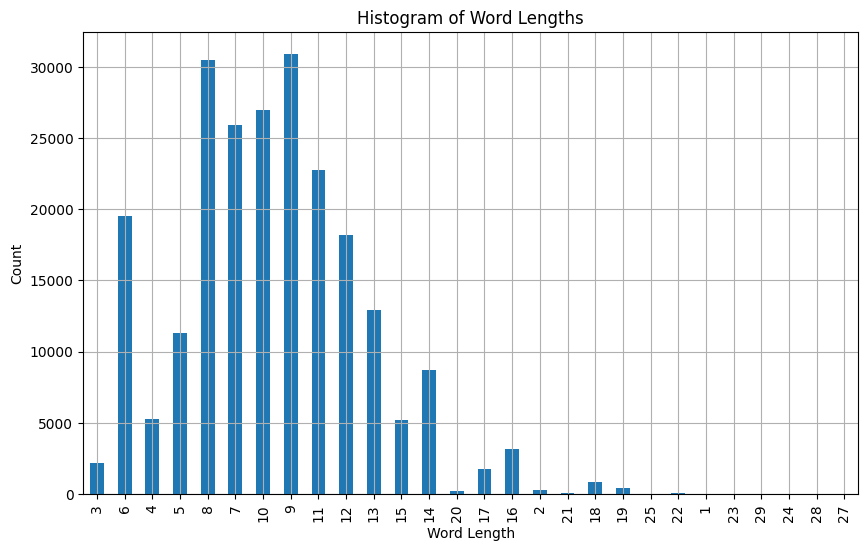

In [ ]:
# Create the histogram
plt.figure(figsize=(10,6))
length_counts_series.plot(kind='bar')
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Histogram of Word Lengths')
plt.grid(True)
plt.show()

In [ ]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []

        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()

        self.current_dictionary = []

    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link


    # The function guess is defined with self and word as parameters. self refers to the instance of the class where this function is defined.
    # word is the word to be guessed, with unknown letters as underscores (e.g., "_ p p _ e").
    def guess(self, word):

      # The function then creates a "clean" version of the input word. It removes spaces and replaces underscores with dots (.),
      # which are used as a wildcard in regular expressions.
      clean_word = word[::2].replace("_", ".")
      len_word = len(clean_word)

      # The function counts the number of known letters in the word and stores them in the existed_letters list.
      Current_existed_letters = []
      existed_letters_length = 0
      for letter in clean_word:
          if letter != '.':
              existed_letters_length += 1
              if letter not in Current_existed_letters:
                  Current_existed_letters.append(letter)

      # The function then updates the current_dictionary with words from the dictionary that match the current state of the word to be guessed.
      # If a word in the dictionary matches the regular expression created from the clean word, it's added to the new_dictionary.
      current_dictionary = self.current_dictionary
      new_dictionary = []
      for dict_word in current_dictionary:
          if len(dict_word) != len_word:
              continue
          if re.match(clean_word, dict_word):
              new_dictionary.append(dict_word)
      self.current_dictionary = new_dictionary




      # Next, the function decides the length n for the n-grams to be used based on the length of the word.
      # An n-gram is a contiguous sequence of n items from a given sample of text or speech.It then creates a list of n-grams from the full dictionary.
      n = min(len_word - 2, 6)
      if len_word <= 3:
          n = len_word - 1
      n_character_dictionary = []
      for word in self.full_dictionary:
          if len(word) > (n - 1):
              for i in range(0, len(word) - (n - 1)):
                  n_character_dictionary.append(word[i:i + n])
      n_character = collections.Counter(n_character_dictionary)
      n_sorted_letter_count = n_character.most_common()
      word_n_gram_collection = []
      for i in range(0, len(clean_word) - (n - 1)):
          word_n_gram_collection.append(clean_word[i:i + n])


      # The function then creates a list of n-grams from the word to be guessed and
      # selects the n-gram with the least number of dots (i.e., unknown characters).
      selected_n_gram = ""
      periodcount = 100
      for grams in word_n_gram_collection:
          if grams.count('.') < periodcount and grams.count('.') > 0:
              selected_n_gram = grams
              periodcount = grams.count('.')


      # The function creates a new dictionary of n-grams that match the selected n-gram from the word to be guessed.
      # The function then counts the occurrences of each character in the n-grams dictionary and sorts them.
      n_gram_dictionary = []
      for dict_word in n_character_dictionary:
          if re.match(selected_n_gram, dict_word):
              n_gram_dictionary.append(dict_word)
      n_gram_string = "".join(n_gram_dictionary)
      c4 = collections.Counter(n_gram_string)
      matched_n_gram_sorted = c4.most_common()


      # Finally, the function tries to guess the next letter based on several strategies:
      # 1) It first checks the most common letters in the full dictionary and chooses one that hasn't been guessed yet.
      guess_letter = '!'
      for letter, instance_count in self.full_dictionary_common_letter_sorted:
          if letter not in self.guessed_letters and existed_letters_length < int(len_word / 2):
              guess_letter = letter
              break
      # 2) If the first method fails, it then checks the most common letters in the matched n-grams and chooses one that hasn't been guessed yet.
      if guess_letter == '!':
          for letter, instance_count in matched_n_gram_sorted:
              if letter not in self.guessed_letters:
                  guess_letter = letter
                  break
      # 3) If both methods fail, it defaults back to the most common letters in the full dictionary and chooses one that hasn't been guessed yet.
      if guess_letter == '!':
          sorted_letter_count = self.full_dictionary_common_letter_sorted
          for letter, instance_count in sorted_letter_count:
              if letter not in self.guessed_letters:
                  guess_letter = letter
                  break
      return guess_letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################

    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary

        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)

                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))

                try:
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e

                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"

    def my_status(self):
        return self.request("/my_status", {})

    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object.
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [ ]:
api = HangmanAPI(access_token="5b73bd142a1cbce103383e60d983d1", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [ ]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


Successfully start a new game! Game ID: 103e24e15bf9. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '103e24e15bf9', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ '}
Guessing letter: i
Sever response: {'game_id': '103e24e15bf9', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ _ '}
Guessing letter: a
Sever response: {'game_id': '103e24e15bf9', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ a _ _ a '}
Guessing letter: n
Sever response: {'game_id': '103e24e15bf9', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ a _ _ a '}
Guessing letter: o
Sever response: {'game_id': '103e24e15bf9', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ o _ _ a _ _ a '}
Guessing letter: r
Sever response: {'game_id': '103e24e15bf9', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ o _ _ a _ _ a '}
Guessing letter: s
Sever response: {'game_id': '103e24e15bf9', 'status': 'ong

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [ ]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)

    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: ignored

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [ ]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.525
